3. Group Proposed Project (10 marks)
3.1 At this point, you understand the data quite well. Carry out the analysis you proposed
in your group project proposal. You should use the dataset given but you may also use
additional datasets to supplement your analysis, look at unaggregated data, etc. Please
be sure to justify why the analysis is useful and interesting in the context of a data science
project. Note that you are not limited to the initial proposal and are free to expand on
it.
3.2 Based on the insights derived from the analysis, suggest a practical action that can be
taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as
hyperparameter tuning here).

In [2]:
WINDOW_SIZE = 5
CLUSTER_COUNT = 50

In [3]:
import requests
import csv
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm


In [4]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Convert to datetime iso


def toIso(dt):
    return datetime.fromisoformat(dt)


def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(
            f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file):  # check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir, is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year, '/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
        # create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file
        df = pd.read_json(fDir)
        for heading in ("total_lots", "lot_type", "lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])

        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df

    def api_call_to_json(year, month, day, hour, minute, second):
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        return response_API, data

    fail_count = 0
    max_time_diff, time_diff = 25, 0
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)

    while not is_file_local and time_diff <= max_time_diff and fail_count < error_count:  # If file doesn't exist, api call
        new_min = str(int(minute) + time_diff)
        response_API, data = api_call_to_json(
            year, month, day, hour, new_min, new_min)

        # check if response is valid
        if response_API.ok and "items" in data and len(data["items"]) > 0 and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
            break
        elif time_diff < max_time_diff:
            time_diff += 1
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)
        else:
            fail_count += 1
            time_diff = 0
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)

    df = read_from_file(fDir)
    return df


# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"]


def addDayHour(df, day, hour):
    df["day"] = day
    df["hour"] = hour
    return df


def removeCountTotal(df):
    df = df.drop(columns=['lots_available', 'total_lots'])
    return df


In [5]:

carpark_rates_dir = f'./data/hdb-carpark-information.csv'
coord_df = pd.read_csv(carpark_rates_dir) 
coord_df[["car_park_no","x_coord","y_coord"]]

,car_park_no,x_coord,y_coord
0,ACB,30314.7936,31490.4942
1,ACM,33758.4143,33695.5198
2,AH1,29257.7203,34500.3599
3,AK19,28185.4359,39012.6664
4,AK31,29482.0290,38684.1754
...,...,...,...
2177,Y77M,29850.1522,45576.0125
2178,Y78M,30057.2209,45166.4820
2179,Y8,27772.9219,45686.2734
2180,Y82M,29935.5818,45679.7181


In [6]:
carparks = set()
location = dict()
for index,row in coord_df[["car_park_no","x_coord","y_coord"]].iterrows():
    carparks.add(row["car_park_no"])
    if row["car_park_no"] not in location:
        location[row["car_park_no"]] = [row["x_coord"],row["y_coord"]]
print(len(carparks),len(location))

2182 2182


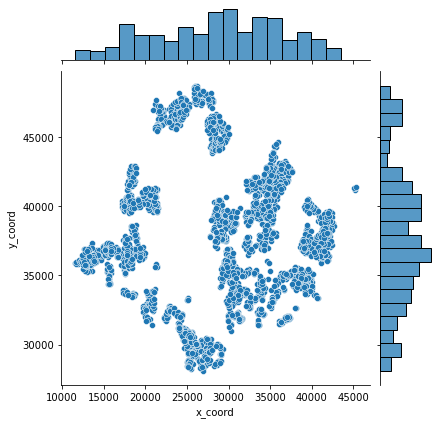

In [7]:
sns.jointplot(data=coord_df,x='x_coord',y='y_coord')

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

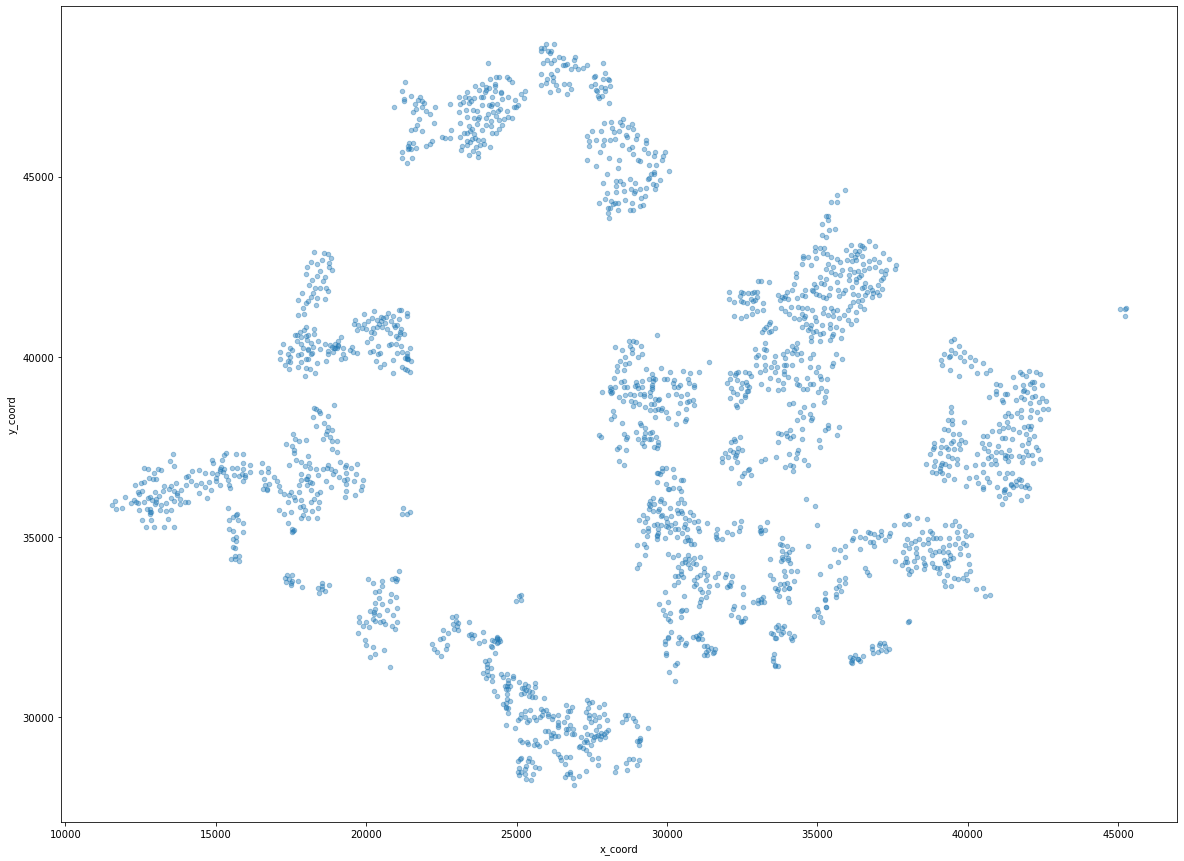

In [8]:
coord_df.plot(x="x_coord",y="y_coord",kind="scatter",alpha=0.4,figsize=(20,15))

Seperating the carparks into cluster by using k-means clustering

In [9]:
scaler = StandardScaler()
coord_df[["x_coord_T","y_coord_T"]] = scaler.fit_transform(coord_df[["x_coord","y_coord"]])

In [10]:
def optimise_k_means(data,max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

In [11]:
# optimise_k_means(coord_df[["x_coord_T","y_coord_T"]],50)

In [12]:
kmeans = KMeans(n_clusters=CLUSTER_COUNT,random_state = 1)
kmeans.fit(coord_df[["x_coord_T","y_coord_T"]])

KMeans(n_clusters=50, random_state=1)

In [13]:
coord_df["kmeans"] = kmeans.labels_
coord_df = coord_df[["car_park_no","x_coord","y_coord","kmeans"]]

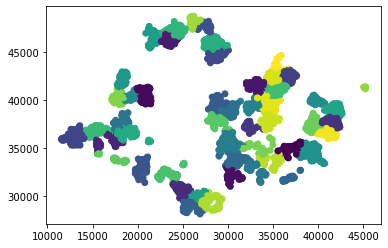

In [14]:
plt.scatter(x=coord_df["x_coord"],y=coord_df["y_coord"],c=coord_df["kmeans"])
plt.show()

In [15]:
def merge_on_col(df1,df2,col1,col2):
    return pd.merge(df1, df2, left_on=col1, right_on=col2, how='right').drop(col1, axis=1)

In [16]:
# start date 15 June 2022 0101

year = 2022
month = 6
day = 15
hour = 1
minute = 1
second = 1
ls=[]
datetime_df = datetime(year=year, month=month, day=day, hour=hour)
dt_interval = timedelta(hours = 1)
total_hrs = 24*7*19 #24 hours, 7 days a week, 19 weeks
clutster_dataframes = [[] for a in range(CLUSTER_COUNT)]
# day of week,time of day
train_x = []
# avalibility percentage
train_y = []
failed = []
for hr in tqdm(range(total_hrs)):
    try:
        datetime_df = datetime_df + dt_interval
        data = carparkApiCall(str(datetime_df.year), str(datetime_df.month), str(datetime_df.day), str(datetime_df.hour), str(datetime_df.minute), str(datetime_df.second), 5)
        new_df = merge_on_col(coord_df,data,"car_park_no","carpark_number")
        new_df1 = new_df.groupby(["kmeans"]).sum()
        new_df1['percentage_avalible'] = new_df1.apply(lambda row: row.lots_available/row.total_lots, axis=1)
        for cluster_no, row in new_df1.iterrows():
            clutster_dataframes[int(cluster_no)].append([datetime_df,row['percentage_avalible']])
    except:
        failed.append(datetime_df)
        continue
pdddd = pd.DataFrame(failed)


  0%|          | 0/3192 [00:00<?, ?it/s]

In [17]:
pdddd

""


In [18]:
def df_to_X_y(df, window_size=WINDOW_SIZE):
  df_as_np = df.to_numpy().flatten()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [19]:
def train_models(clutster_dataframes):
    best_models = []
    train_results,val_results,test_results = [],[],[]
    counter = 0
    for cluster in tqdm(clutster_dataframes):
        dff = pd.DataFrame(np.array(cluster),columns=["datetime","percentage"]).set_index("datetime")
        X1, y1 = df_to_X_y(dff, WINDOW_SIZE)
        length = len(X1)
        first,second = int(length*4/6),int(length-length/6)
        X_train1, y_train1 = X1[:first], y1[:first]
        X_val1, y_val1 = X1[first:second], y1[first:second]
        X_test1, y_test1 = X1[second:], y1[second:]
        
        best_models, train_results, val_results, test_results, counter = train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1)
        retry_count = 0
        best_model_in_retry = None
        best_mse_in_retry = 99999
        best_test_results_in_retry = None
        best_val_results_in_retry = None
        best_train_results_in_retry = None
        while mean_squared_error(test_results[-1]['Test Predictions'], test_results[-1]['Actuals']) > 0.001 and retry_count < 10:
            retry_count += 1
            if best_mse_in_retry > mean_squared_error(test_results[-1]['Test Predictions'], test_results[-1]['Actuals']):
                best_model_in_retry = best_models[-1]
                best_test_results_in_retry = test_results[-1]
                best_val_results_in_retry = val_results[-1]
                best_train_results_in_retry = train_results[-1]
                best_mse_in_retry = mean_squared_error(
                    test_results[-1]['Test Predictions'], test_results[-1]['Actuals'])
            print(counter-1, mean_squared_error(
                test_results[-1]['Test Predictions'], test_results[-1]['Actuals']), retry_count)
            test_results.pop()
            val_results.pop()
            train_results.pop()
            best_models.pop()
            counter -= 1
            
            best_models, train_results, val_results, test_results, counter = train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1)
        
        if retry_count >= 10:
            test_results.pop()
            val_results.pop()
            train_results.pop()
            best_models.pop()
            test_results.append(best_test_results_in_retry)
            val_results.append(best_val_results_in_retry)
            train_results.append(best_train_results_in_retry)
            best_models.append(best_model_in_retry)
            
                
    return train_results,val_results,test_results,best_models

def train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1):
    model1 = Sequential()
    model1.add(InputLayer((WINDOW_SIZE, 1)))
    model1.add(LSTM(64))
    model1.add(Dense(8, 'relu'))
    model1.add(Dense(1, 'linear'))
        
    if counter == 0:
        print("shape(original):",X1.shape, y1.shape)
        print("shape(train,val,test):",X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)
        print(model1.summary())
        
    cp1 = ModelCheckpoint(f'model1/lstm{counter}.h5', save_best_only=True)        
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()])
    model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=200, callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor = 'val_mean_squared_error',
            min_delta=0.00001,
            patience = 10)
            ,cp1],verbose=0)
    
    model1 = load_model(f'model1/lstm{counter}.h5', compile=False)
    best_models.append(model1)
    counter+=1
        
    train_predictions = model1.predict(X_train1,verbose=0).flatten()
    train_results.append(pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1}))
        
    val_predictions = model1.predict(X_val1,verbose=0).flatten()
    val_results.append(pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1}))
        
    test_predictions = model1.predict(X_test1,verbose=0).flatten()
    test_results.append(pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1}))
    
    return best_models, train_results, val_results, test_results, counter
    

In [20]:
len(clutster_dataframes)

50

In [21]:
# run this cell to train models

# train_results,val_results,test_results,best_models = train_models(clutster_dataframes)

In [22]:
def get_train_models(clutster_dataframes):
    best_models = []
    train_results,val_results,test_results = [],[],[]
    counter = 0
    for cluster in tqdm(clutster_dataframes):
        dff = pd.DataFrame(np.array(cluster),columns=["datetime","percentage"]).set_index("datetime")
        X1, y1 = df_to_X_y(dff, WINDOW_SIZE)
        length = len(X1)
        first,second = int(length*4/6),int(length-length/6)
        X_train1, y_train1 = X1[:first], y1[:first]
        X_val1, y_val1 = X1[first:second], y1[first:second]
        X_test1, y_test1 = X1[second:], y1[second:]
        
        best_models, train_results, val_results, test_results, counter = get_train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1)
            
                
    return train_results,val_results,test_results,best_models

def get_train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1):    
    model1 = load_model(f'model1/lstm{counter}.h5', compile=False)
    best_models.append(model1)
    counter+=1
    if counter == 0:
        print("shape(original):",X1.shape, y1.shape)
        print("shape(train,val,test):",X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)
        print(model1.summary())
        
    # train_predictions = model1.predict(X_train1,verbose=0).flatten()
    # train_results.append(pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1}))
        
    # val_predictions = model1.predict(X_val1,verbose=0).flatten()
    # val_results.append(pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1}))
        
    test_predictions = model1.predict(X_test1,verbose=0).flatten()
    test_results.append(pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1}))
    
    return best_models, train_results, val_results, test_results, counter

In [23]:
#run this cell if models already trained
train_results,val_results,test_results,best_models = get_train_models(clutster_dataframes)


  0%|          | 0/50 [00:00<?, ?it/s]

cluster: 0 mse: 0.00027969024542126136


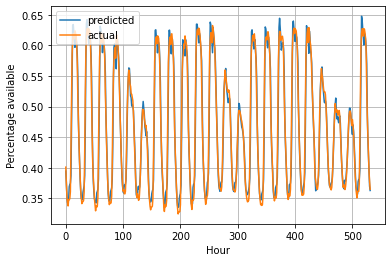

cluster: 1 mse: 0.0007490393439446761


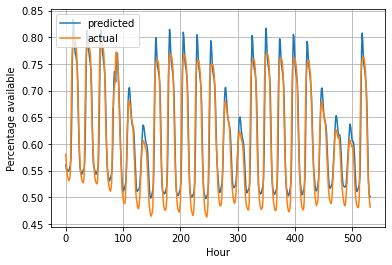

cluster: 2 mse: 0.0007865637783862549


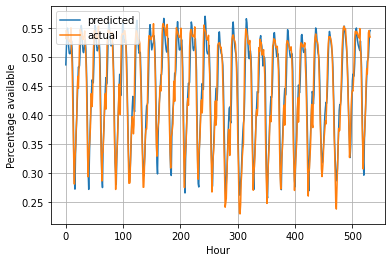

cluster: 3 mse: 0.0005783466375107282


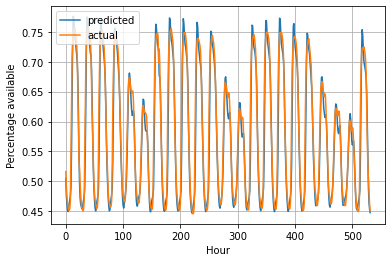

cluster: 4 mse: 0.0003940067553216289


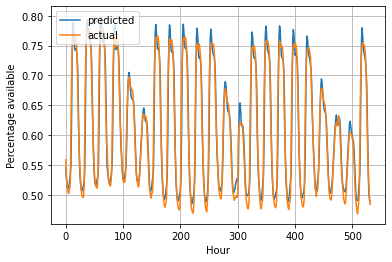

cluster: 5 mse: 0.0005228427485587244


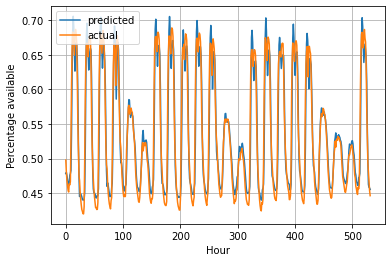

cluster: 6 mse: 0.00016614720602124052


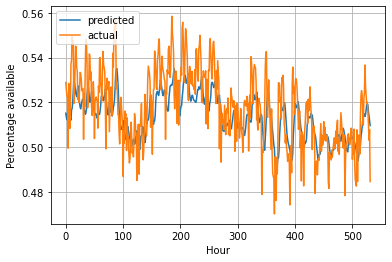

cluster: 7 mse: 0.0003867368273047046


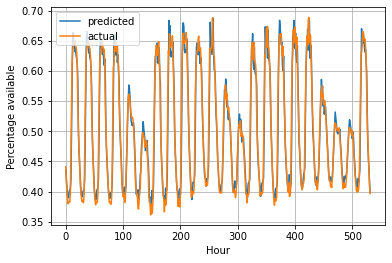

cluster: 8 mse: 0.00032461611494269833


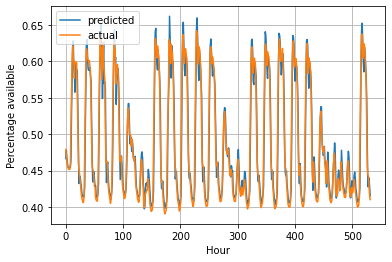

cluster: 9 mse: 0.0004020628236041038


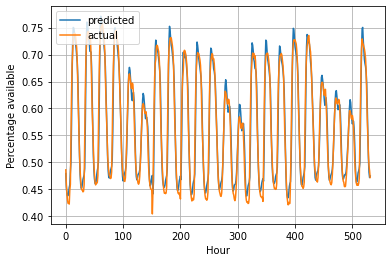

cluster: 10 mse: 0.0003688916626725532


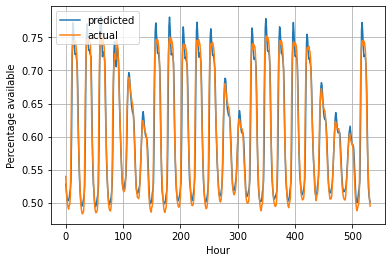

cluster: 11 mse: 0.0003142520071038305


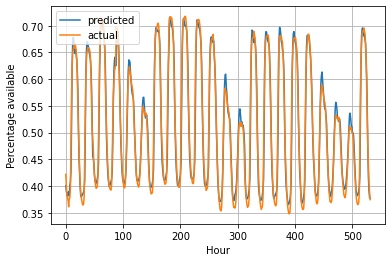

cluster: 12 mse: 0.000554486126363033


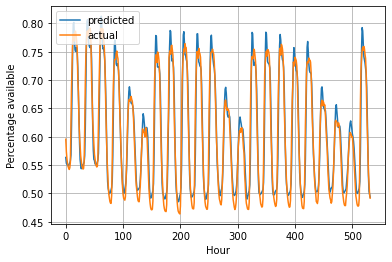

cluster: 13 mse: 0.0006134775061653218


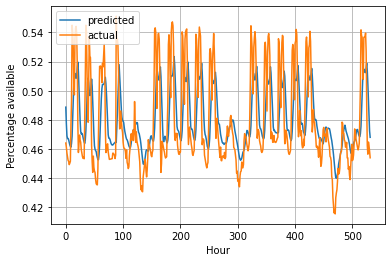

cluster: 14 mse: 0.0003325657757513587


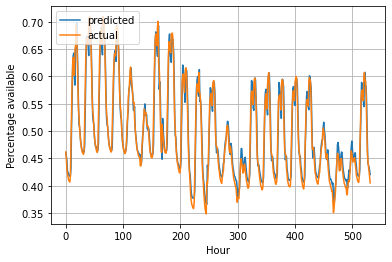

cluster: 15 mse: 0.00022433660693952116


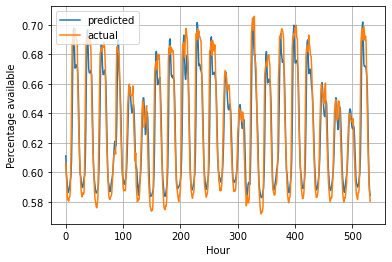

cluster: 16 mse: 0.0005031855728687392


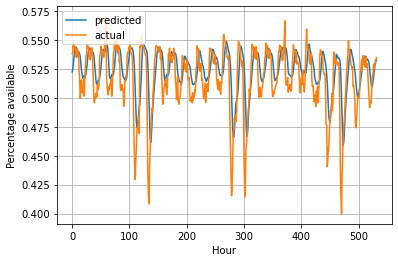

cluster: 17 mse: 0.0003804222996276889


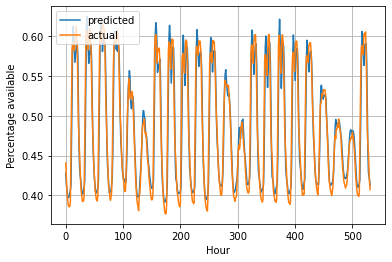

cluster: 18 mse: 0.0004028018627594583


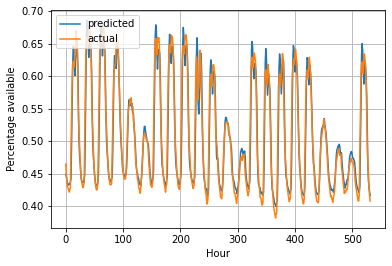

cluster: 19 mse: 0.0004285330598135317


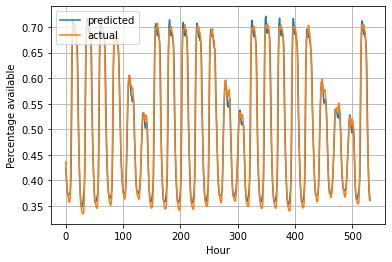

cluster: 20 mse: 0.0008574378171324103


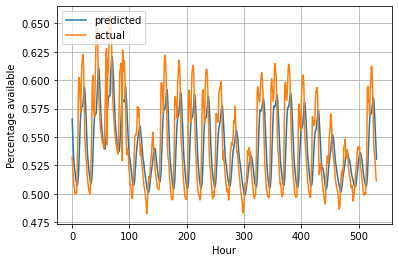

cluster: 21 mse: 0.00026135135400171694


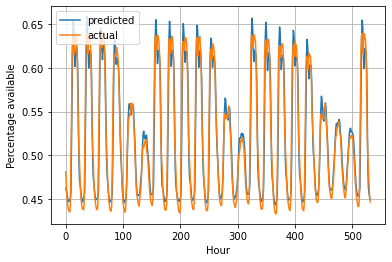

cluster: 22 mse: 0.00040030924576880733


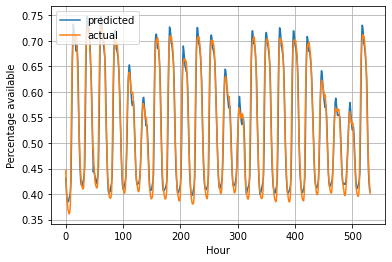

cluster: 23 mse: 0.00037807299044000315


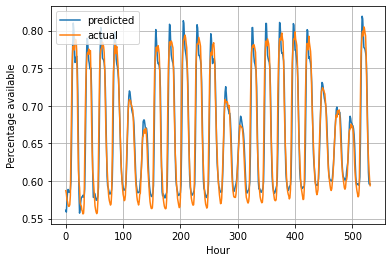

cluster: 24 mse: 0.0005378484367823583


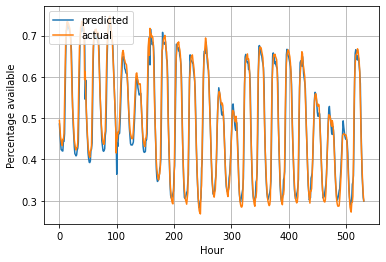

cluster: 25 mse: 0.00043629437694799674


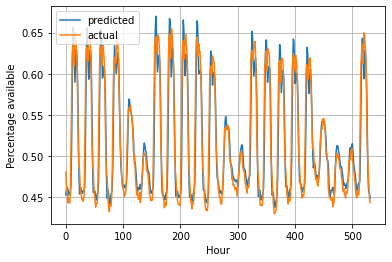

cluster: 26 mse: 0.0003807617575443961


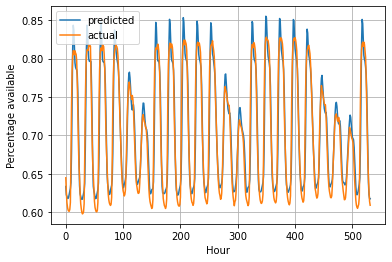

cluster: 27 mse: 0.00042506027748921807


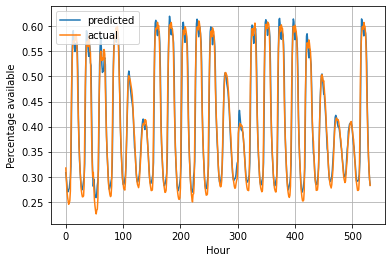

cluster: 28 mse: 0.00010566783272173243


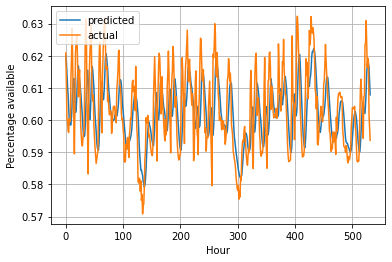

cluster: 29 mse: 0.000557709742901597


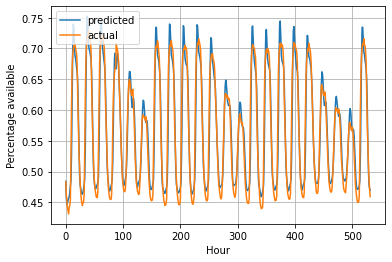

cluster: 30 mse: 0.00025856759639118326


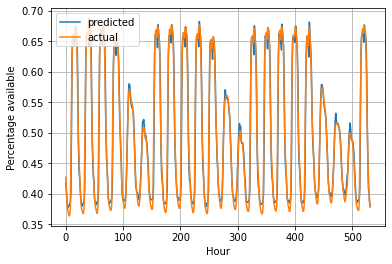

cluster: 31 mse: 0.0002682012458919598


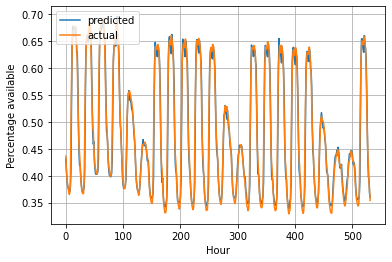

cluster: 32 mse: 0.0003960311603245404


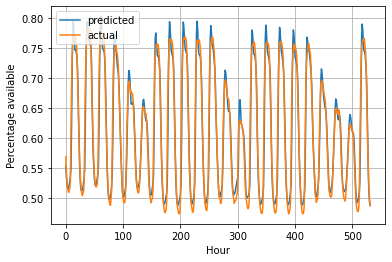

cluster: 33 mse: 0.0003877600732875901


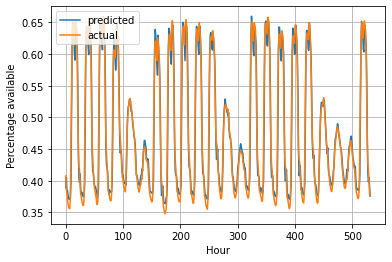

cluster: 34 mse: 0.0003716949518734082


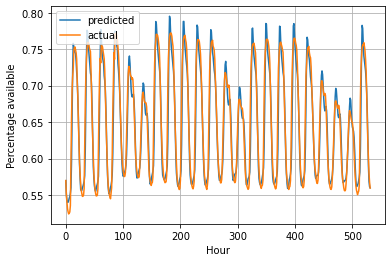

cluster: 35 mse: 0.0007436718765276064


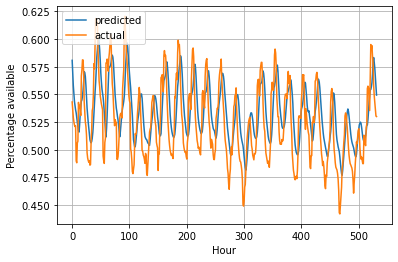

cluster: 36 mse: 0.00045894506007871413


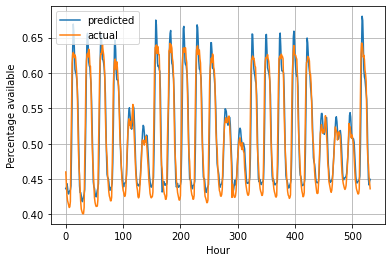

cluster: 37 mse: 0.0005808769023036586


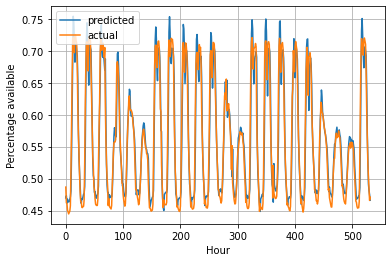

cluster: 38 mse: 0.0006127789181150825


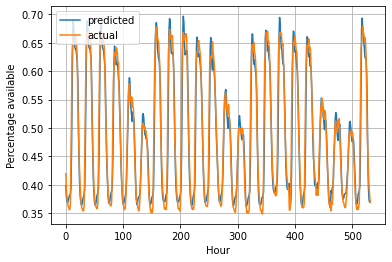

cluster: 39 mse: 0.00033727692008799794


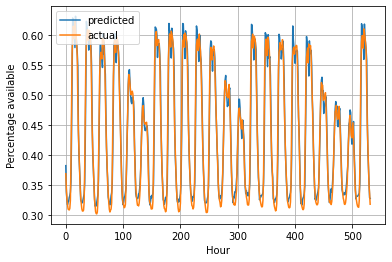

cluster: 40 mse: 0.0007149556142289705


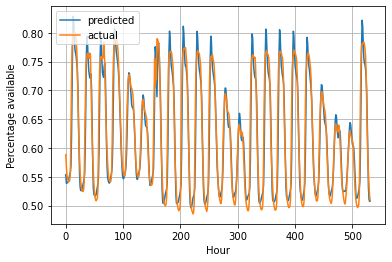

cluster: 41 mse: 0.003134122886212799


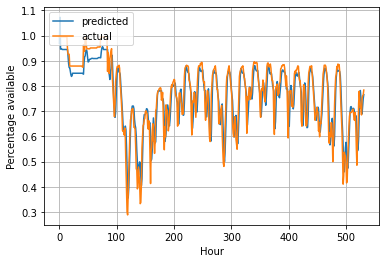

cluster: 42 mse: 0.0003357843736254857


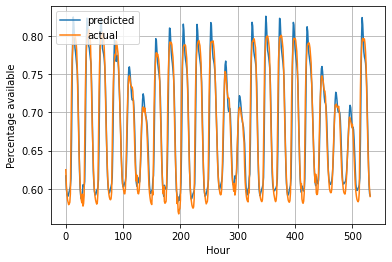

cluster: 43 mse: 0.0008830380368102724


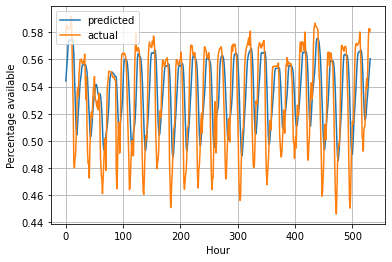

cluster: 44 mse: 0.0008683428225424433


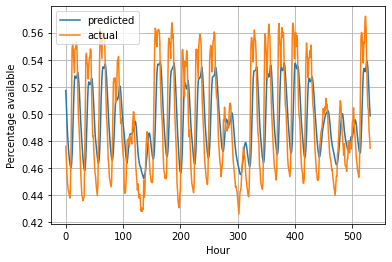

cluster: 45 mse: 0.0005157095383946181


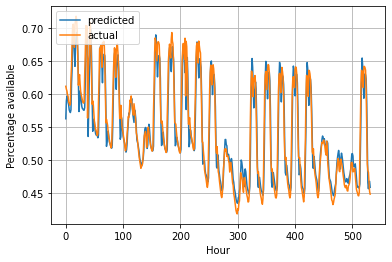

cluster: 46 mse: 0.0004457202455239984


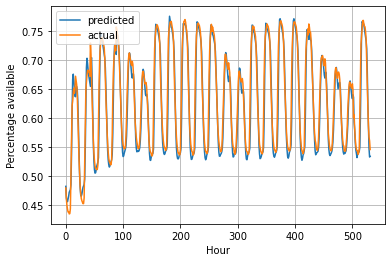

cluster: 47 mse: 0.00041686896983655127


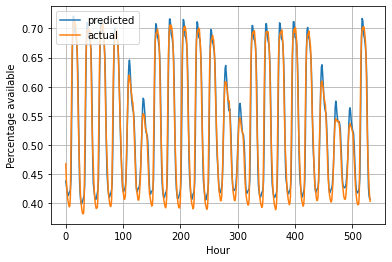

cluster: 48 mse: 0.0003601113877325977


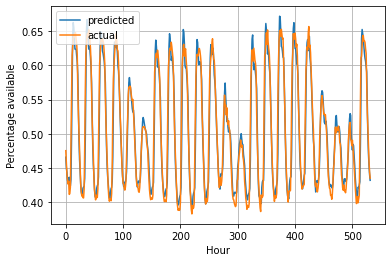

cluster: 49 mse: 0.00037221618471801267


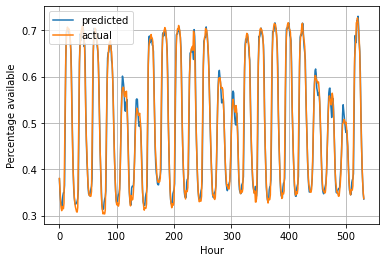

In [24]:
for i in range(len(test_results)):
    # plt.plot(train_results[i]['Train Predictions'])
    # plt.plot(train_results[i]['Actuals'])
    
    # plt.plot(val_results[i]['Val Predictions'])
    # plt.plot(val_results[i]['Actuals'])
    print("cluster:",i,f"mse: {mean_squared_error(test_results[i]['Test Predictions'], test_results[i]['Actuals'])}")
    
    plt.plot(test_results[i]['Test Predictions'], label ='predicted')
    plt.plot(test_results[i]['Actuals'], label ='actual')
    
    plt.grid(True)
    plt.xlabel("Hour")
    plt.ylabel("Percentage available")
    plt.legend(loc='upper left')
    plt.show()

In [25]:
def plot(i):
    # plt.plot(train_results[i]['Train Predictions'])
    # plt.plot(train_results[i]['Actuals'])

    # plt.plot(val_results[i]['Val Predictions'])
    # plt.plot(val_results[i]['Actuals'])

    plt.plot(test_results[i]['Test Predictions'])
    plt.plot(test_results[i]['Actuals'])

In [67]:

for cluster in clutster_dataframes:
        derp = pd.DataFrame(np.array(cluster),columns=["datetime","percentage"]).set_index("datetime")
        no, yes = df_to_X_y(derp, WINDOW_SIZE)

In [120]:
def predict_cluster_at_time(dt, cluster, models):
    #get current time and subtract 5 hours,
    currtime = datetime.now()
    dt = datetime(currtime.year, currtime.month, currtime.day, currtime.hour, 1, 0)
    #get clustered data for each timestamp
    currdata = []
    dt_interval = timedelta(hours = 1)

    for i in range(5):
        #get api call for current time
        try:
            apival = merge_on_col(coord_df, carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 10), "car_park_no", "carpark_number")
            apival = apival.groupby(["kmeans"]).sum().dropna(how='all')
            currdata.append(np.array(avrAvail(apival))[cluster]) 
            dt = dt - dt_interval
        except Exception as e:
            print(e)
            print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))

    currdata.reverse()
    # #run through RNN 
    data = np.array(currdata).reshape(1,5,1)
    print(data)
    pred = models[cluster].predict(data)
    print(pred)


currtime = datetime.now()
timedelt = timedelta(hours = 1)

dt = datetime(currtime.year, currtime.month, currtime.day, currtime.hour, 1, 0) + timedelt
predict_cluster_at_time(dt, 5, best_models)

[[[0.59411261]
  [0.54956779]
  [0.52402461]
  [0.50401059]
  [0.48648859]]]
1/1 [==============================] - 0s 20ms/step
[[0.47489208]]
